* Import Statements

In [ ]:
#!pip install citipy

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from citipy import citipy

# Dataset Cleanup

* DataType Cleanups.  Import the file.   Change the column data types.

In [ ]:
#Import the raw file
ufo_df = pd.read_csv("Data/scrubbed.csv")

#Convert the datetime to a datetime.  Drop any bad rows.
ufo_df['datetime']= pd.to_datetime(ufo_df['datetime'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['datetime'])

#Convert the date posted to a datetime.  Drop any bad rows.
ufo_df['date posted']= pd.to_datetime(ufo_df['date posted'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['date posted'])

#Convert the duration (seconds) posted to a float.  Drop any bad rows.
ufo_df['duration (seconds)']= pd.to_numeric(ufo_df['duration (seconds)'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['duration (seconds)'])

#Convert the latitude posted to a number.  Drop any bad rows.
ufo_df['latitude']= pd.to_numeric(ufo_df['latitude'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['latitude'])

#Fix the name.  Drop any bad rows.
ufo_df.rename(inplace=True,columns={'longitude ':'longitude', 'duration (seconds)':'duration' })
ufo_df = ufo_df.dropna(subset=['longitude'])

* Cleanup the column values for city and country.  Use citipy, with the latitude and longitude.  By the way these columns looked like they were swapped ('latitude' is 'longitude', and vice-versa).

In [ ]:
for i,row in ufo_df.iterrows():
    ufo_df.at[i,'city'] = citipy.nearest_city(row['latitude'],row['longitude']).city_name.strip()
    ufo_df.at[i,'country'] = citipy.nearest_city(row['latitude'],row['longitude']).country_code.strip()

* Drop uneeded columns.

In [ ]:
del ufo_df['duration (hours/min)']
del ufo_df['comments']


* Split out the datetime into seperate columns so its easier to work with.

In [ ]:
ufo_df['year'] = ufo_df['datetime'].dt.year
ufo_df['month'] = ufo_df['datetime'].dt.month
ufo_df['day'] = ufo_df['datetime'].dt.day
ufo_df['hour'] = ufo_df['datetime'].dt.hour
ufo_df['minute'] = ufo_df['datetime'].dt.minute

ufo_df.head()

# Observations and Data Visualizations

## Which are the top 10 countries do ufo sightings occur the most?

In [47]:
#Create a dataframe from a group by.  
most_ufo_by_country_df = pd.DataFrame(ufo_df.groupby(['country'])['datetime'].count())
most_ufo_by_country_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_country_df['percentage'] = most_ufo_by_country_df['counts']/most_ufo_by_country_df['counts'].sum()*100
most_ufo_by_country_df['percentage'] = most_ufo_by_country_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_country_df = most_ufo_by_country_df.reset_index()

most_ufo_by_country_df1 = most_ufo_by_country_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_country_df1.sort_values(by='counts', ascending=False)

,country,counts,percentage
138,us,70133,88.07%
24,ca,3788,4.76%
48,gb,2339,2.94%
8,au,625,0.78%
94,mx,270,0.34%
64,in,219,0.28%
36,de,132,0.17%
98,nl,113,0.14%
19,br,108,0.14%
101,nz,99,0.12%


## Visualize the sightings by top 10 countries across the last 25 years.

In [95]:
# Create a dataframe from a group by country and year.  
most_ufo_by_country_year_df = pd.DataFrame(ufo_df.groupby(['country','year'])['datetime'].count())
# Fix the name of the count column.
most_ufo_by_country_year_df.rename(inplace=True,columns={'datetime':'counts'})

# Pull the 'country','year' out of the index so we can use the unique on it below.
most_ufo_by_country_year_df = most_ufo_by_country_year_df.reset_index()


#most_ufo_by_country_year_df.head()

# Pull out just the top 10 countries we need.
most_ufo_by_country_year_df1 = pd.merge(most_ufo_by_country_year_df, most_ufo_by_country_df1, how="inner", on="country")

#Fix the count name due to the merge
most_ufo_by_country_year_df1 = most_ufo_by_country_year_df1.rename(columns={'counts_x':'counts'})

# Drop the count column from the top 10 countries.
del most_ufo_by_country_year_df1['counts_y']



# This one was a serious pain in the ass so its worth explaining.
# We are creating columns for every country and years for the rows.
# We have to create an index with every possible year, beacuse if we don't the first country to hit loop will
# set the index.  I spent hours trying to figure this out.
most_ufo_by_country_year_df2 = pd.DataFrame(index=pd.Index(most_ufo_by_country_year_df['year'].unique()).sort_values())

# Rename the index so its clear.
most_ufo_by_country_year_df2.index.names=['year']

#Put the index back so it can be used in the loop.
most_ufo_by_country_year_df1 = most_ufo_by_country_year_df1.set_index(['year'])

most_ufo_by_country_year_df1.head()
for country in most_ufo_by_country_year_df1['country'].unique():
     most_ufo_by_country_year_df2[country] = most_ufo_by_country_year_df1[most_ufo_by_country_year_df1['country'] == country]['counts']

most_ufo_by_country_year_df2 = most_ufo_by_country_year_df2.reset_index()
most_ufo_by_country_year_df2 = most_ufo_by_country_year_df2.fillna(0)
most_ufo_by_country_year_df2.sort_values(by='year', ascending=False).head(25)



,year,au,br,ca,de,gb,in,mx,nl,nz,us
86,2014,13.0,2.0,62.0,3.0,25.0,13.0,3.0,1.0,1.0,2093.0
85,2013,38.0,2.0,314.0,5.0,61.0,22.0,15.0,1.0,5.0,6440.0
84,2012,23.0,3.0,309.0,7.0,99.0,25.0,9.0,3.0,5.0,6697.0
83,2011,15.0,5.0,170.0,4.0,57.0,4.0,13.0,2.0,0.0,4702.0
82,2010,18.0,2.0,167.0,4.0,134.0,5.0,8.0,8.0,6.0,3811.0
81,2009,17.0,6.0,162.0,6.0,257.0,12.0,9.0,8.0,6.0,3923.0
80,2008,24.0,5.0,145.0,17.0,182.0,13.0,15.0,2.0,5.0,4281.0
79,2007,30.0,8.0,190.0,13.0,152.0,23.0,19.0,6.0,4.0,3720.0
78,2006,48.0,7.0,187.0,3.0,195.0,14.0,21.0,4.0,6.0,3098.0
77,2005,54.0,5.0,229.0,5.0,128.0,9.0,17.0,8.0,7.0,3472.0


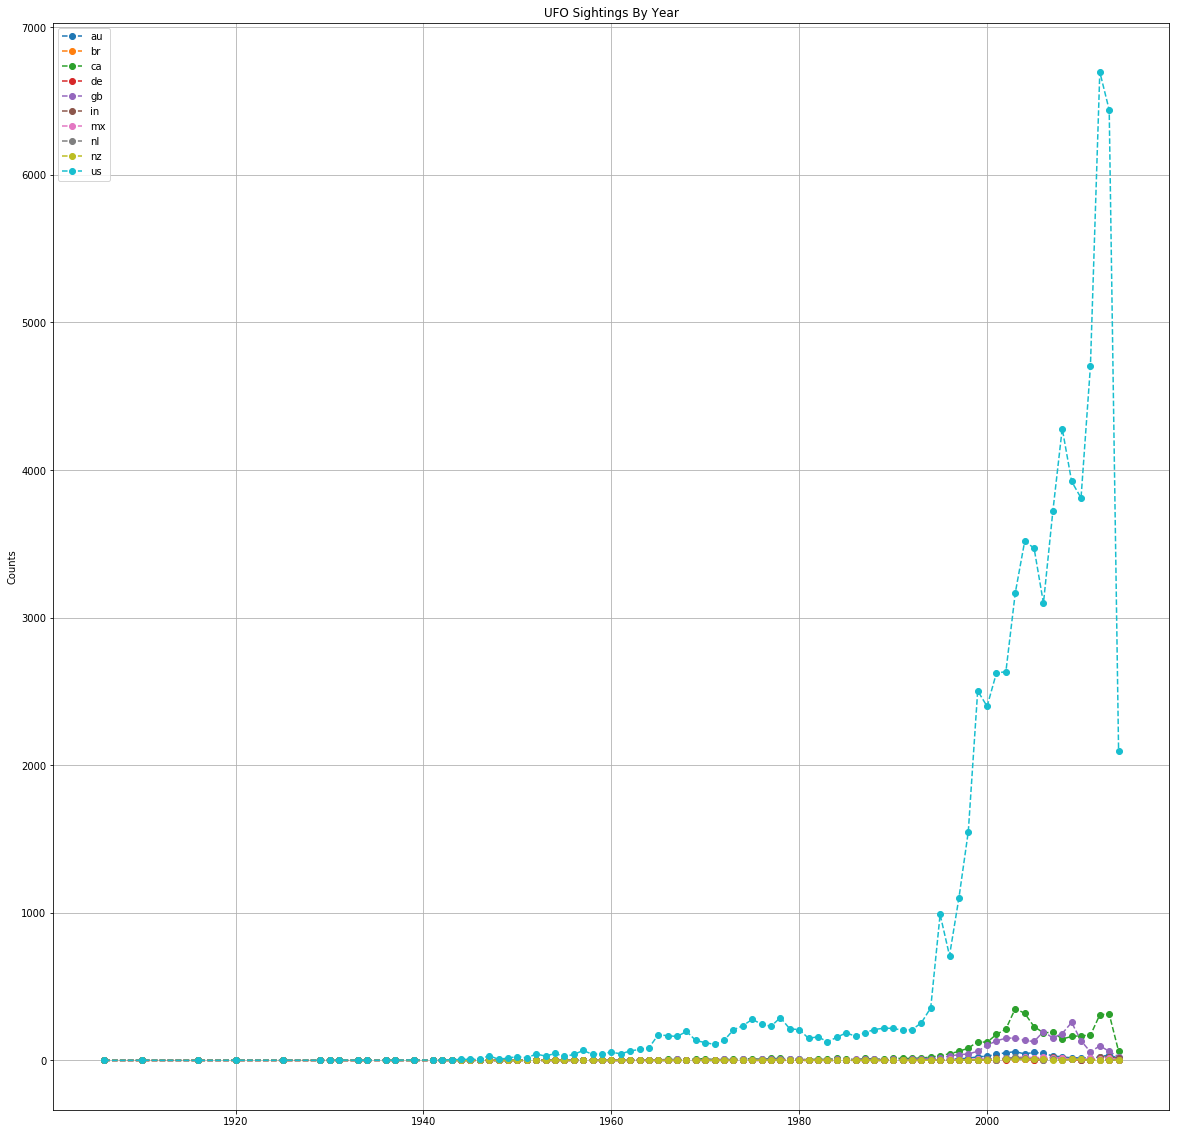

In [96]:
fig, axes = plt.subplots(1,1,sharex=True, sharey=True, figsize=(20,20))

#Turn on the grid
axes.grid()
for column in most_ufo_by_country_year_df2:
    if column != 'year':
        axes.errorbar(x=most_ufo_by_country_year_df2['year'], y=most_ufo_by_country_year_df2[column], \
                     label=column, \
                     linestyle='dashed', marker='o'
                     )

# Plot title
plt.title('UFO Sightings By Year')
axes.set_ylabel('Counts')
# Create a legend
plt.legend(loc='upper left' )
plt.show()


In [97]:
#Create a dataframe from a group by.  
most_ufo_by_shape_df = pd.DataFrame(ufo_df.groupby(['shape'])['datetime'].count())
most_ufo_by_shape_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['counts']/most_ufo_by_shape_df['counts'].sum()*100
#most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_shape_df = most_ufo_by_shape_df.reset_index()

most_ufo_by_shape_df1 = most_ufo_by_shape_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_shape_df1.sort_values(by='counts', ascending=False)

,shape,counts,percentage
18,light,16465,21.178211
26,triangle,7813,10.049521
4,circle,7532,9.688083
13,fireball,6166,7.931057
19,other,5591,7.191459
27,unknown,5532,7.115570
24,sphere,5341,6.869895
11,disk,5138,6.608785
20,oval,3699,4.757862
16,formation,2442,3.141038


In [ ]:
#Visualization of ufo sightings across the world. Seems rather odd the US has 90% of them¶

In [106]:
# # This was a pain to install
#  import geopandas
#  from shapely.geometry import Point

# most_ufo_by_city_df['Coordinates'] = list(zip(most_ufo_by_city_df['longitude'], most_ufo_by_city_df['latitude']))
# most_ufo_by_city_df['Coordinates'] = most_ufo_by_city_df['Coordinates'].apply(Point)

# gdf = geopandas.GeoDataFrame(most_ufo_by_city_df, geometry='Coordinates')

IndentationError: unexpected indent (<ipython-input-106-c0ceb0eaeb67>, line 2)

In [ ]:
# world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(50,50))
# gdf.plot(ax=ax, marker='o', color='red', markersize=2)
# plt.show()

## Which cities have the most ufo sightings?

In [101]:
most_ufo_by_city_df = pd.DataFrame(ufo_df.groupby(['city','state','country', 'longitude','latitude'])['datetime'].count())
most_ufo_by_city_df.rename(inplace=True,columns={'datetime':'counts'})
most_ufo_by_city_df['percentage'] = most_ufo_by_city_df['counts']/most_ufo_by_city_df['counts'].sum()*100
most_ufo_by_city_df['percentage'] = most_ufo_by_city_df['percentage'].map('{:,.2f}%'.format)
most_ufo_by_city_df = most_ufo_by_city_df.reset_index()
most_ufo_by_city_df.sort_values(by='counts', ascending=False).head(15)

,city,state,country,longitude,latitude,counts,percentage
14477,seattle,wa,us,-122.330833,47.606389,577,0.78%
11060,new york,ny,us,-74.006389,40.714167,520,0.70%
12476,phoenix,az,us,-112.073333,33.448333,470,0.64%
8721,las vegas,nv,us,-115.136389,36.175000,388,0.52%
9290,los angeles,ca,us,-118.242778,34.052222,388,0.52%
14175,san diego,ca,us,-117.156389,32.715278,359,0.49%
12933,portland,or,us,-122.675000,45.523611,342,0.46%
7373,houston,tx,us,-95.363056,29.763056,307,0.42%
2980,chicago,il,us,-87.650000,41.850000,286,0.39%
16167,tucson,az,us,-110.925833,32.221667,245,0.33%


In [ ]:
#Which UFO shape is the most common?

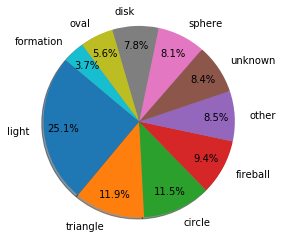

In [53]:
# Build Pie Chart
#Add the figure
fig, axes = plt.subplots(1,1,sharex=True, sharey=True)
#explode = (.1, 0, .1) 
colors=['gold','lightblue','red']
axes.pie(most_ufo_by_shape_df1['percentage'], \
         labels=most_ufo_by_shape_df1['shape'], \
         #explode=explode, colors=colors, \
         autopct='%1.1f%%', shadow=True, startangle=140, \
         radius = 1.1, labeldistance = 1.15, pctdistance=.8
        )
plt.show()

In [ ]:
#Which City Are Most UFOs seen?

NameError: name 'most_ufo_by_city_year_df' is not defined

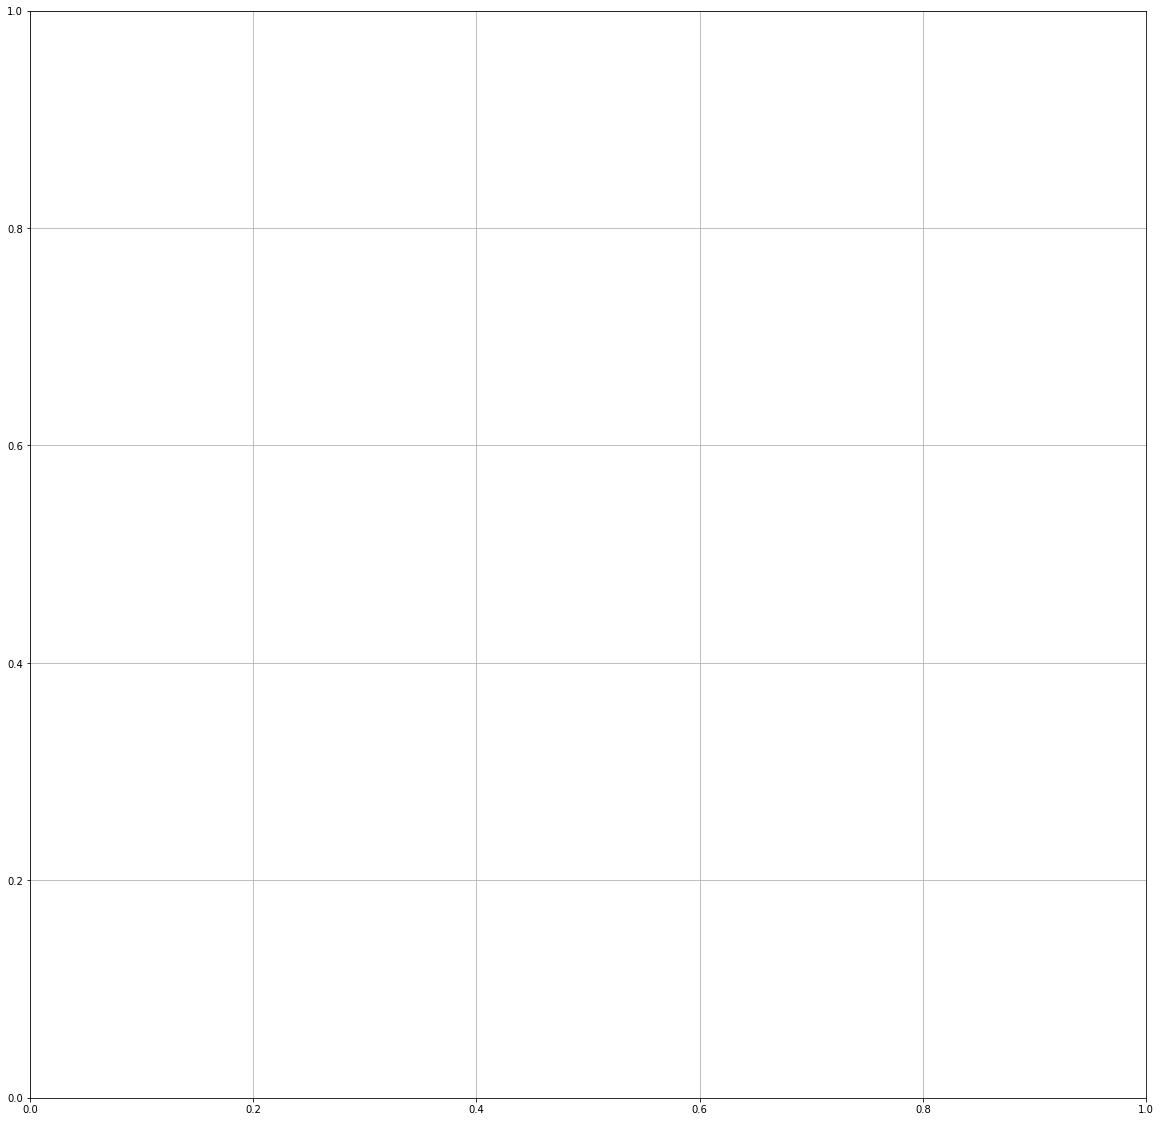

In [108]:
fig, axes = plt.subplots(1,1,sharex=True, sharey=True, figsize=(20,20))

#Turn on the grid
#axes.grid()
#for column in most_ufo_by_city_year_df:
 #   if column != 'year':
  #      axes.errorbar(x=most_ufo_by_city_df['counts'], y=most_ufo_by_city_df['counts'], \
   #                  label=column, \
    #                 linestyle='dashed', marker='o'
     #                )

# Plot title
plt.title('UFO Sightings By City')
axes.set_ylabel('Counts')
# Create a legend
plt.legend(loc='upper left' )
plt.show()



# More ideas
* Are ufo sitings increasing or decreasing.
   Visualization: A bar chart showing year as the x axis, and the siting counts as the y axis.

* Do you see more lights at night?
    Visualization: Shapes versus Time of day.  Bar chart x is shape, time of day is y.
* What is the best place to see a ufo?
    Visualization: The top 10 places to see a UFO over the last 5 years.  Table or barchart

For each of the top 10 places:

* What month should you go?
* What time should you look outside?
* What shape should you look for?